In [1]:
%run imports.ipynb

In [78]:
li2016_calls = pd.read_excel('source_data/variant_calls.xlsx', sheet_name='Li2016')
li2016_calls.rename({'Name': 'name'}, axis=1).to_csv('source_data/li2016_variant_calls.csv', index=False)

li2016_calls = pd.read_csv('source_data/li2016_variant_calls.csv')
sample2status = {r.name:r.status for r in li2016_calls.to_records()}

run2status = {r.run_rrbs:r.status for r in li2016_calls.to_records()}

In [97]:
context2bed = {
    'cgi': 'beds/hg38.cgi.sorted.bed',
    'cpg_shore': 'beds/hg38.cgi_shores.pure.sorted.bed',
    'cpg_shelf': 'beds/hg38.cgi_shelves.pure.sorted.bed',
    'promoter': 'beds/gencode.v32.promoter.sorted.bed',
    'methylation_canyon': 'beds/methylation_canyons_hg38.sorted.bed',
    'exon': 'beds/gencode.v32.exon.pure.sorted.bed',
    'genebody': 'beds/gencode.v32.genebody.pure.sorted.bed',
    'sine': 'beds/sine.sorted.bed',
    'line': 'beds/line.sorted.bed',
    'ltr': 'beds/ltr.sorted.bed',
    'bivalent_domain': '/data/project/SNUH_DNMT3A/note2/results/CHROMATIN-STATES/bivalent_domains.sorted.bed',
    'bivalent_promoter': 'beds/gencode.v32.bivalent_promoter.sorted.bed',
    'nonbivalent_promoter': 'beds/gencode.v32.nonbivalent_promoter.sorted.bed',
    'bivalent_promoter_bivslop1000': 'beds/gencode.v32.bivalent_promoter.bivslop1000.sorted.bed',
    'nonbivalent_promoter_bivslop1000': 'beds/gencode.v32.nonbivalent_promoter.bivslop1000.sorted.bed',
    # 'panel': '/data/project/SNUH_DNMT3A/note2/results/BS-PANEL-SELECTION/panel.sorted.bed',
}

contexts = [
    'cgi', 'cpg_shore', 'cpg_shelf', 'promoter',
    'methylation_canyon', 'exon', 'genebody', 'sine', 'line', 'ltr',
    'bivalent_domain', 'bivalent_promoter', 'nonbivalent_promoter', 'bivalent_promoter_bivslop1000', 'nonbivalent_promoter_bivslop1000',
    'all', 'intergenic',
]

### Context-specific LPMD 계산 결과 정리

In [98]:
result_dir = '/data3/project/SNUH_DNMT3A/pipelines/METHEOR/result/DBGAP-ERRBS/'

data = []
for run, status in tqdm(run2status.items()):
    for context in contexts:
        tmp = pd.read_csv(result_dir + f'{run}.{context}.lpmd.tsv', sep='\t')

        tmp['run'] = run
        tmp['context'] = context
        tmp['status'] = status

        data.append(tmp.drop('name', axis=1))
        
data = pd.concat(data)[['run', 'status', 'context', 'lpmd']]

100%|██████████| 108/108 [00:08<00:00, 12.91it/s]


In [99]:
data.to_csv('source_data/context_specific_lpmd.csv', index=False)

In [100]:
data = pd.read_csv('source_data/context_specific_lpmd.csv')

In [101]:
context2cpgcount = {
    'all': 1371701,
    'intergenic': 85712,
    'promoter': 665169,
    'cgi': 704068,
    'cpg_shore': 175413,
    'cpg_shelf': 95173,
    'sine': 189338,
    'line': 20257,
    'ltr': 38142,
    'genebody': 405623,
    'exon': 114353,
    'methylation_canyon': 206354,
    'bivalent_domain': 223428,
}

In [102]:
data.context.unique()

array(['cgi', 'cpg_shore', 'cpg_shelf', 'promoter', 'methylation_canyon',
       'exon', 'genebody', 'sine', 'line', 'ltr', 'bivalent_domain',
       'bivalent_promoter', 'nonbivalent_promoter',
       'bivalent_promoter_bivslop1000',
       'nonbivalent_promoter_bivslop1000', 'all', 'intergenic'],
      dtype=object)

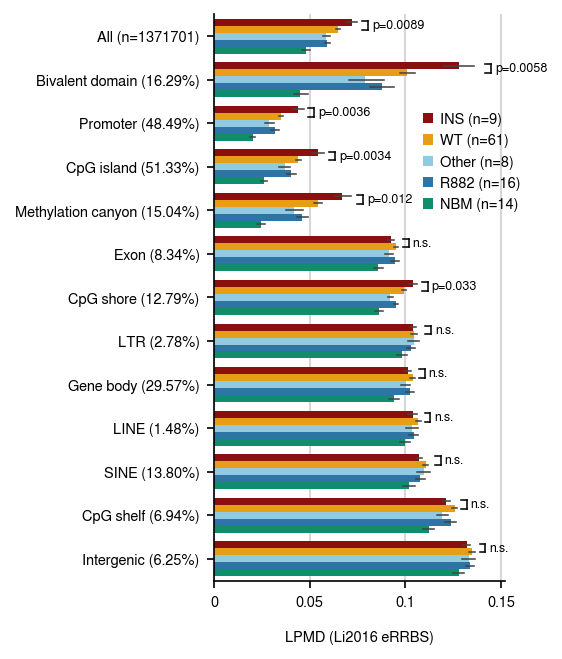

In [200]:
from scipy.stats import ttest_ind, mannwhitneyu
from matplotlib.ticker import FormatStrFormatter

format_context = {
    'all': 'All',
    'promoter': 'Promoter',
    'cgi': 'CpG island',
    'methylation_canyon': 'Methylation canyon',
    'exon': 'Exon',
    'genebody': 'Gene body',
    'sine': 'SINE',
    'intergenic': 'Intergenic',
    'cpg_shelf': 'CpG shelf',
    'ltr': 'LTR',
    'line': 'LINE',
    'cpg_shore': 'CpG shore',
    'bivalent_domain': 'Bivalent domain',
    'bivalent_promoter': 'Bivalent promoter',
    'nonbivalent_promoter': 'Non-bivalent promoter',
}

plt.rc('lines', linewidth=0.75)

# order = ['all', 'bivalent_domain'] + data[~data.context.isin(['all', 'bivalent_domain', 'nonbivalent_promoter', 'bivalent_promoter', 'nonbivalent_promoter_bivslop1000', 'bivalent_promoter_bivslop1000'])].groupby('context').agg({'lpmd': 'mean'}).reset_index().sort_values('lpmd').context.tolist()
order = [
    'all',
    'bivalent_domain',
    'promoter',
    'cgi',
    'methylation_canyon',
    'exon',
    'cpg_shore',
    'ltr',
    'genebody',
    'line',
    'sine',
    'cpg_shelf',
    'intergenic',
]
hue_order = ['INS', 'WT', 'Other', 'R882', 'NBM']
palette = ['#990000', 'orange', 'skyblue', 'C0', '#009e73']

fig = plt.figure(figsize=(2.5, 5))
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
ax.grid(axis='x', lw=1, alpha=0.5)

data_grouped = data.groupby(['run', 'context']).agg({'n_concordant': 'sum', 'n_discordant': 'sum', 'status': 'first'}).reset_index()
data_grouped['lpmd'] = data_grouped.n_discordant / (data_grouped.n_discordant + data_grouped.n_concordant)

sns.barplot(
    data=data_grouped,
    y='context',
    x='lpmd',
    hue='status',
    hue_order=hue_order,
    order=order,
    palette=palette,
    orient='h',
    ci=68,
    errwidth=0.75,
    saturation=0.8,
)

for i, context in enumerate(order):
    d = data_grouped[data_grouped.context == context]
    
    a = d[(d.status == 'WT')].lpmd
    b = d[(d.status == 'INS')].lpmd
    p = mannwhitneyu(a, b).pvalue
    
    max_x = 0
    for status in ['INS', 'WT', 'Other', 'R882', 'NBM']:
        tmp = data_grouped[(data_grouped.context == context) & (data_grouped.status == status)]
        max_x = np.max([max_x, tmp.lpmd.mean() + d.lpmd.std() / np.sqrt(len(tmp))])
                            
    # Plot significance indicators.
    ax.plot([max_x + 0.005, max_x + 0.005], [i - 0.35, i - 0.15], c='k')
    ax.plot([max_x + 0.002, max_x + 0.005], [i - 0.35, i - 0.35], c='k')
    ax.plot([max_x + 0.002, max_x + 0.005], [i - 0.15, i - 0.15], c='k')
    
    if p < 0.05:
        ax.text(max_x + 0.007, i - 0.25, f'p={p:.2g}', va='center', ha='left', fontsize=6)
#     if p < 0.01:
#         ax.text(max_x + 0.007, i - 0.125, f'**', va='center', ha='left', fontsize=7)
#     elif p < 0.05:
#         ax.text(max_x + 0.007, i - 0.125, f'*', va='center', ha='left', fontsize=7)
    else:
        ax.text(max_x + 0.007, i - 0.25, f'n.s.', va='center', ha='left', fontsize=6)
    
ax.set_xlabel('LPMD (Li2016 eRRBS)', fontsize=7, labelpad=10)
ax.set_ylabel('')
ax.set_ylim([-0.5, len(order) - 0.5])
ax.invert_yaxis()

# xticklabels = [t.get_text() for t in ax.get_xticklabels()]
# xticklabels[0] = '0'
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
# print(x)
# ax.set_xticklabels(xticklabels)
# ax.set_xticklabels([0] + list([t.get_position()[0] for t in xticklabels[1:]]))
ax.set_yticklabels([f'{format_context[c]} (n={context2cpgcount["all"]})' if c == 'all' else f'{format_context[c]} ({context2cpgcount[c] / context2cpgcount["all"]:.2%})' for c in order])

handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels[:5]:
    new_labels.append(label + ' (n=%d)' % (np.sum(d['status'] == label)))
handles = handles[:5]
ax.legend(handles, new_labels, frameon=False, fontsize=7, loc='upper right', handlelength=0.7, handletextpad=0.5, bbox_to_anchor=(1.1, 0.85))

for d in ['top', 'right']:
    ax.spines[d].set_visible(False)

save_figures('source_data_figures/lpmd_context_analysis/lpmd_context_full')

In [180]:
data[(data.context == context) & (data.status == 'WT')].groupby('run').agg({''})

,run,context,status,distance,n_concordant,n_discordant,lpmd
368,SRR3088187,intergenic,WT,2,155158,14416,0.085013
369,SRR3088187,intergenic,WT,3,156747,18179,0.103924
370,SRR3088187,intergenic,WT,4,150228,19954,0.117251
371,SRR3088187,intergenic,WT,5,150719,19895,0.116608
372,SRR3088187,intergenic,WT,6,158783,21261,0.118088
...,...,...,...,...,...,...,...
36749,SRR3088587,intergenic,WT,20,137883,23150,0.143759
36750,SRR3088587,intergenic,WT,21,139376,27085,0.162711
36751,SRR3088587,intergenic,WT,22,125374,22704,0.153325
36752,SRR3088587,intergenic,WT,23,135418,22259,0.141168


### Bivalent domain context-specific LPMD

In [117]:
tmp = pd.read_csv(result_dir + f'{run}.bivalent_domain.pairs.tsv', sep='\t')

In [118]:
tmp['distance'] = tmp.cpg2 - tmp.cpg1

In [122]:
result_dir = '/data3/project/SNUH_DNMT3A/pipelines/METHEOR/result/DBGAP-ERRBS/'
context = 'bivalent_domain'

data = []
for run, status in tqdm(run2status.items()):
    for context in contexts:
        tmp = pd.read_csv(result_dir + f'{run}.{context}.pairs.tsv', sep='\t')
        tmp['distance'] = tmp.cpg2 - tmp.cpg1
        tmp = tmp.groupby('distance').agg({'n_concordant': 'sum', 'n_discordant': 'sum'}).reset_index().assign(lpmd=lambda x: x.n_discordant / (x.n_concordant + x.n_discordant))
        
        tmp['run'] = run
        tmp['context'] = context
        tmp['status'] = status

        data.append(tmp)
        
data = pd.concat(data)[['run', 'context', 'status', 'distance', 'n_concordant', 'n_discordant', 'lpmd']]

100%|██████████| 108/108 [31:06<00:00, 17.28s/it]


In [125]:
biv_data.head(3)

,run,context,status,distance,n_concordant,n_discordant,lpmd
0,SRR3088187,cgi,WT,2,10066239,382373,0.036596
1,SRR3088187,cgi,WT,3,8077092,384136,0.045400
2,SRR3088187,cgi,WT,4,6810299,341266,0.047719


In [127]:
biv_data.to_csv('source_data/context_specific_lpmd.bivalent_domain.distance.csv', index=False)

### SINE context-specific LPMD

In [123]:
result_dir = '/data3/project/SNUH_DNMT3A/pipelines/METHEOR/result/DBGAP-ERRBS/'
context = 'sine'

sine_data = []
for run, status in tqdm(run2status.items()):
    for context in contexts:
        tmp = pd.read_csv(result_dir + f'{run}.{context}.pairs.tsv', sep='\t')
        tmp['distance'] = tmp.cpg2 - tmp.cpg1
        tmp = tmp.groupby('distance').agg({'n_concordant': 'sum', 'n_discordant': 'sum'}).reset_index().assign(lpmd=lambda x: x.n_discordant / (x.n_concordant + x.n_discordant))
        
        tmp['run'] = run
        tmp['context'] = context
        tmp['status'] = status

        sine_data.append(tmp)
        
sine_data = pd.concat(sine_data)[['run', 'context', 'status', 'distance', 'n_concordant', 'n_discordant', 'lpmd']]

100%|██████████| 108/108 [41:29<00:00, 23.05s/it]


In [169]:
sine_data.to_csv('source_data/context_specific_lpmd.distance.csv', index=False)

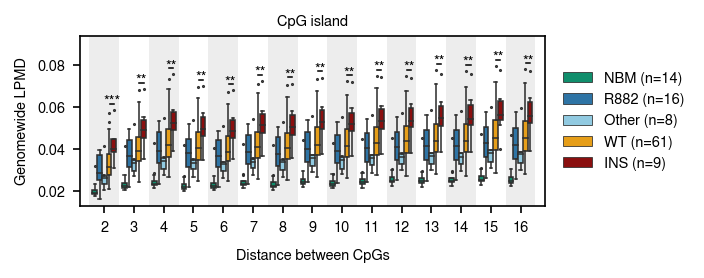

<Figure size 225x225 with 0 Axes>

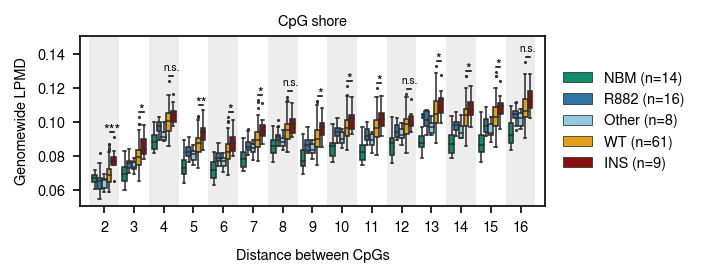

<Figure size 225x225 with 0 Axes>

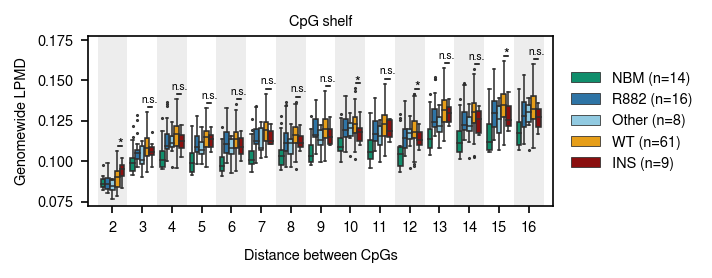

<Figure size 225x225 with 0 Axes>

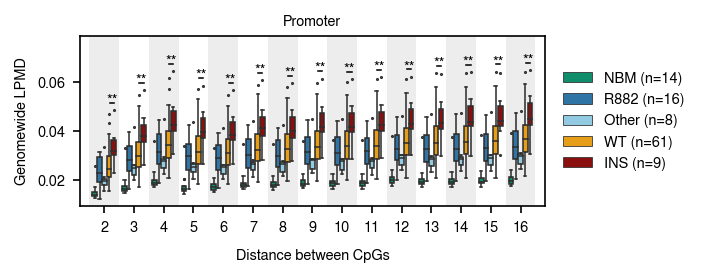

<Figure size 225x225 with 0 Axes>

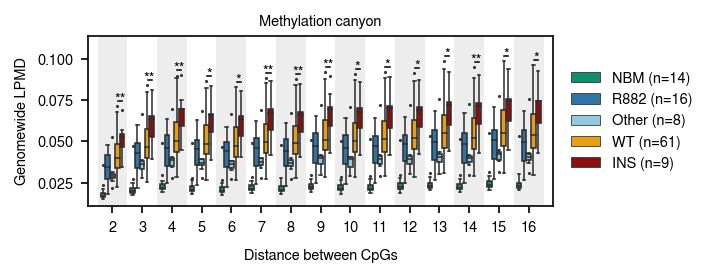

<Figure size 225x225 with 0 Axes>

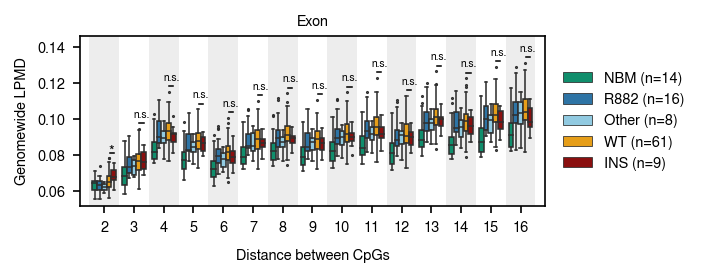

<Figure size 225x225 with 0 Axes>

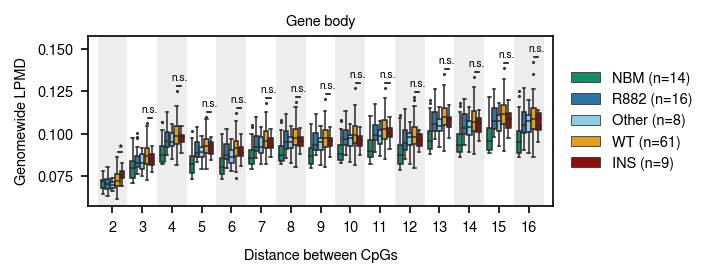

<Figure size 225x225 with 0 Axes>

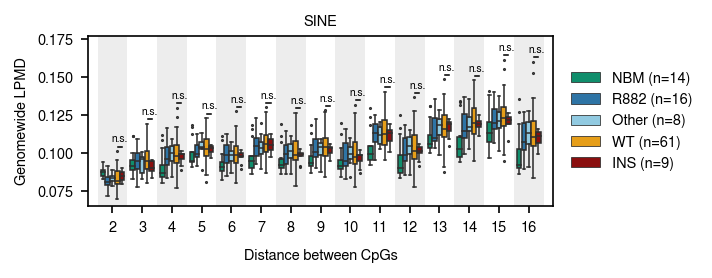

<Figure size 225x225 with 0 Axes>

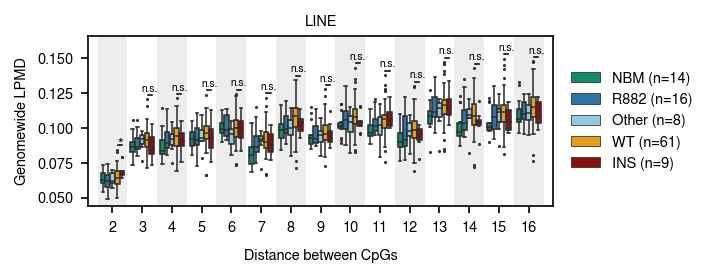

<Figure size 225x225 with 0 Axes>

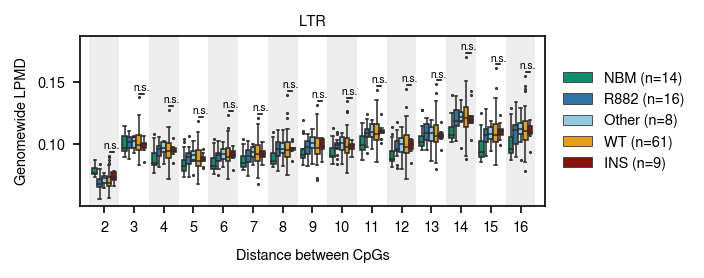

<Figure size 225x225 with 0 Axes>

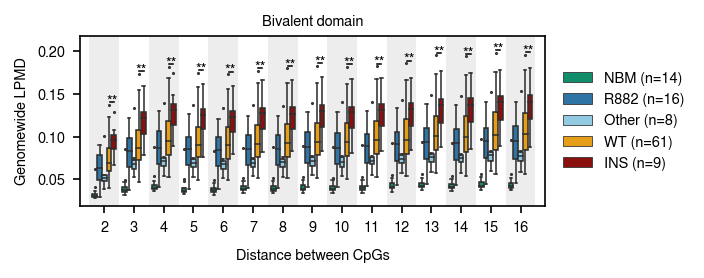

<Figure size 225x225 with 0 Axes>

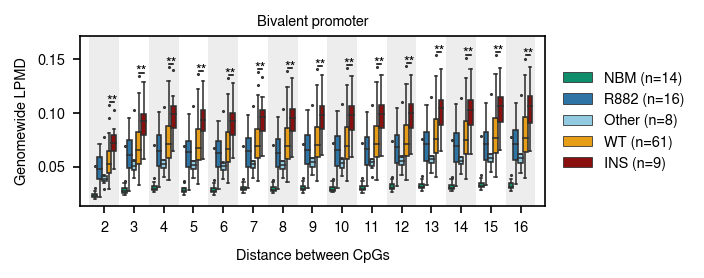

<Figure size 225x225 with 0 Axes>

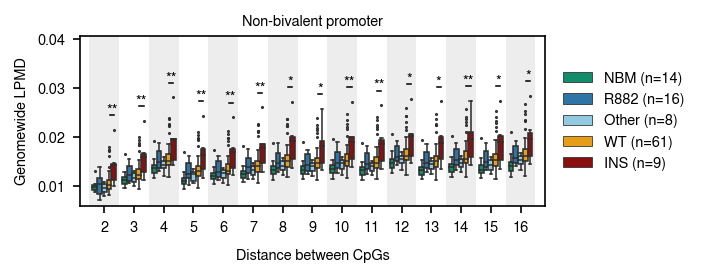

<Figure size 225x225 with 0 Axes>

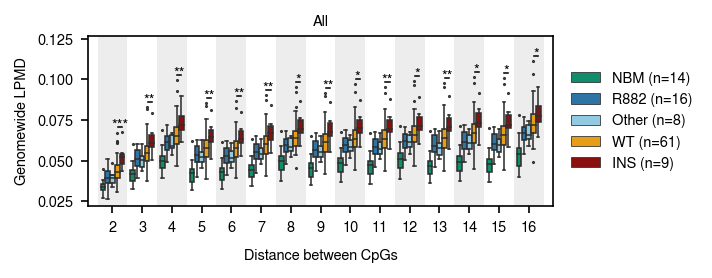

<Figure size 225x225 with 0 Axes>

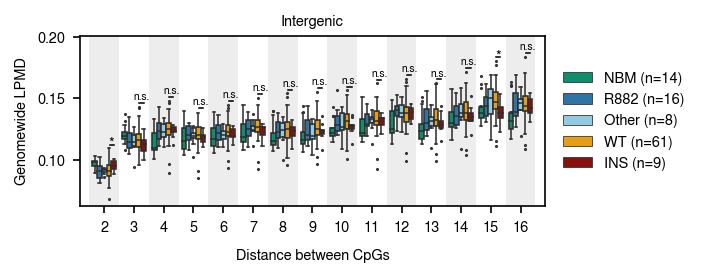

<Figure size 225x225 with 0 Axes>

In [174]:
data = pd.read_csv('source_data/context_specific_lpmd.distance.csv')

MAX_DIST = 16

for context in contexts:
    if context not in format_context:
        continue
        
    tmp = data[(data.distance <= MAX_DIST) & (data.context == context)]

    fig = plt.figure(figsize=(4, 1.5))
    ax = fig.add_subplot(111)

    ax.set_title(format_context[context], pad=5, fontsize=7)

    for i in range(0, 16, 2):
        ax.axvspan(i - 0.5, i + 0.5, facecolor='grey', alpha=0.14, zorder=-1)
        
    sns.boxplot(ax=ax,
                data=tmp, 
                x='distance', 
                y='lpmd', 
                hue='status', 
                fliersize=1,
                flierprops={'marker': '.'},
                palette=['#009e73', 'C0', 'skyblue', 'orange', '#990000'],
                hue_order=['NBM', 'R882', 'Other', 'WT', 'INS'],
                saturation=0.8,
    )

    #     sns.stripplot(ax=ax,
    #                 data=tmp, 
    #                 x='distance', 
    #                 y='lpmd', 
    #                 hue='status', 
    #                 zorder=1,
    #                 palette=['grey'] * 5,
    #     #             color='grey',
    #                 hue_order=['NBM', 'R882', 'Other', 'WT', 'INS'],
    #                 dodge=True,
    #                 size=1,
    #                 rasterized=True,
    #     )

    p_values = []
    for dist in range(2, MAX_DIST + 1):
        p_values.append(mannwhitneyu(
            tmp[(tmp.status == 'INS') & (tmp.distance == dist)].lpmd.values,
            tmp[(tmp.status == 'WT') & (tmp.distance == dist)].lpmd.values,
        ).pvalue)

    for i, (dist, p) in enumerate(zip(range(2, MAX_DIST + 1), p_values)):
        max_y = tmp[tmp.distance == dist].lpmd.max()
        ax.plot([i + 0.18, i + 0.32], [max_y + 3e-3, max_y + 3e-3], c='k')

        asterisk_fontsize = 7
        significance_dy = 4e-3
        if p < 0.001:
            ax.text(i + 0.25, max_y + significance_dy, '***', ha='center', va='center', fontsize=asterisk_fontsize)
        elif p < 0.01:
            ax.text(i + 0.25, max_y + significance_dy, '**', ha='center', va='center', fontsize=asterisk_fontsize)
        elif p < 0.05:
            ax.text(i + 0.25, max_y + significance_dy, '*', ha='center', va='center', fontsize=asterisk_fontsize)
        else:
            ax.text(i + 0.25, max_y + significance_dy * 2, 'n.s.', ha='center', va='center', fontsize=5)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for label in labels[:5]:
        new_labels.append(label + ' (n=%d)' % (np.sum(tmp['status'] == label) / (MAX_DIST - 1)))

    handles = handles[:5]
    ax.set_xlabel(f'Distance between CpGs', labelpad=7, fontsize=7)
    ax.set_ylabel('Genomewide LPMD', fontsize=7)
    ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1] + significance_dy * 2])

    plt.legend(handles, new_labels, frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=7)
    save_figures(f'source_data_figures/lpmd_context_analysis/{context}.lpmd.distance')
    plt.show(); plt.clf()

### Biv/Non-biv promoter results

In [129]:
data = pd.read_csv('source_data/context_specific_lpmd.csv')

In [131]:
data[data.context.isin(['bivalent_promoter', 'nonbivalent_promoter'])]

,run,status,context,lpmd
11,SRR3088187,WT,bivalent_promoter,0.090231
12,SRR3088187,WT,nonbivalent_promoter,0.015933
28,SRR3088190,WT,bivalent_promoter,0.100268
29,SRR3088190,WT,nonbivalent_promoter,0.016147
45,SRR3088192,WT,bivalent_promoter,0.045343
...,...,...,...,...
1797,SRR3088603,NBM,nonbivalent_promoter,0.015276
1813,SRR3088604,NBM,bivalent_promoter,0.031814
1814,SRR3088604,NBM,nonbivalent_promoter,0.013778
1830,SRR3088605,NBM,bivalent_promoter,0.029722


In [133]:
d = data[data.context.isin(['bivalent_promoter', 'nonbivalent_promoter'])]

In [138]:
stats.mannwhitneyu(
    d[(d.context == 'bivalent_promoter') & (d.status == 'WT')].lpmd,
    d[(d.context == 'bivalent_promoter') & (d.status == 'INS')].lpmd,
)

MannwhitneyuResult(statistic=127.0, pvalue=0.004950825458779239)

In [139]:
stats.mannwhitneyu(
    d[(d.context == 'nonbivalent_promoter') & (d.status == 'WT')].lpmd,
    d[(d.context == 'nonbivalent_promoter') & (d.status == 'INS')].lpmd,
)

MannwhitneyuResult(statistic=141.0, pvalue=0.009808267712748803)

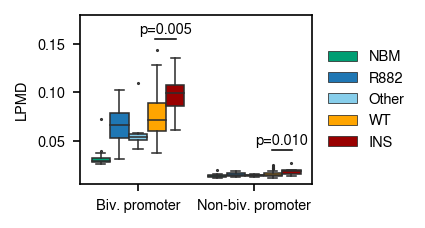

In [157]:
plt.rc('font', family='FreeSans')

fig = plt.figure(figsize=(2, 1.5))
ax = fig.add_subplot(111)

hue_order = ['INS', 'WT', 'Other', 'R882', 'NBM'][::-1]
palette = ['#990000', 'orange', 'skyblue', 'C0', '#009e73'][::-1]

sns.boxplot(
    data=data[data.context.isin(['bivalent_promoter', 'nonbivalent_promoter'])],
    x='context',
    y='lpmd',
    hue='status',
    hue_order=hue_order,
    palette=palette,
    flierprops={'marker': '.', 'markersize': 1.0},
    saturation=1.0,
    ax=ax,
)

ax.legend(frameon=False, bbox_to_anchor=(1.01, 0.5), loc='center left')

ax.set_ylabel('LPMD')
ax.set_xlabel('')

ax.set_xlim([-0.5, 1.5])
ylim_min, ylim_max = ax.get_ylim()
ax.set_ylim([ylim_min, ylim_max + 0.03])

sig_notation_kwargs = {'lw': 0.75, 'c': 'k'}
y = 0.155

stat, p = stats.mannwhitneyu(
    d[(d.context == 'bivalent_promoter') & (d.status == 'WT')].lpmd,
    d[(d.context == 'bivalent_promoter') & (d.status == 'INS')].lpmd,
)

ax.plot([0.15, 0.325], [y, y], **sig_notation_kwargs)
# ax.plot([0.15, 0.15], [y-5e-3, y], **sig_notation_kwargs)
# ax.plot([0.325, 0.325], [y-5e-3, y], **sig_notation_kwargs)
ax.text((0.15 + 0.325) / 2, y + 0.01, f'p={p:.3f}', ha='center', va='center', fontsize=7)

stat, p = stats.mannwhitneyu(
    d[(d.context == 'nonbivalent_promoter') & (d.status == 'WT')].lpmd,
    d[(d.context == 'nonbivalent_promoter') & (d.status == 'INS')].lpmd,
)

y = 0.04
ax.plot([1.15, 1.325], [y, y], **sig_notation_kwargs)
# ax.plot([1.15, 1.15], [y-5e-3, y], **sig_notation_kwargs)
# ax.plot([1.325, 1.325], [y-5e-3, y], **sig_notation_kwargs)
ax.text((1.15 + 1.325) / 2, y + 0.01, f'p={p:.3f}', ha='center', va='center', fontsize=7)

ax.set_xticklabels(['Biv. promoter', 'Non-biv. promoter'], ha='center')

save_figures('source_data_figures/lpmd_context_analysis/li2016_biv_nonbiv_promoter_lpmd')